<a href="https://colab.research.google.com/github/KimNa0/Section2_Project/blob/main/AI_13_%EA%B9%80%EB%82%98%EC%98%81_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install --upgrade category_encoders

import pandas as pd
import seaborn as sns

from category_encoders import OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

from sklearn.model_selection import RandomizedSearchCV
import sklearn
from xgboost import XGBClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [23]:
train = pd.read_csv("train.csv", index_col = 0)
test = pd.read_csv("test_x.csv", index_col = 0)

train.shape, test.shape

((45532, 77), (11383, 76))

In [24]:
train.head()

,QaA,QaE,QbA,QbE,QcA,QcE,QdA,QdE,QeA,QeE,...,wr_04,wr_05,wr_06,wr_07,wr_08,wr_09,wr_10,wr_11,wr_12,wr_13
index,,,,,,,,,,,,,,,,,,,,,
0,3.0,363,4.0,1370,5.0,997,1.0,1024,2.0,1577,...,0,1,0,1,1,0,1,0,1,1
1,5.0,647,5.0,1313,3.0,3387,5.0,2969,1.0,4320,...,1,1,0,1,1,0,1,0,1,1
2,4.0,1623,1.0,1480,1.0,1021,4.0,3374,5.0,1333,...,1,1,0,1,1,1,1,0,1,1
3,3.0,504,3.0,2311,4.0,992,3.0,3245,1.0,357,...,0,0,0,0,1,0,1,0,1,1
4,1.0,927,1.0,707,5.0,556,2.0,1062,1.0,1014,...,1,1,1,1,1,0,1,1,1,1


In [25]:
#voted 1,2 → 0,1
train['voted'] = train['voted'] -1

In [26]:
train.T.duplicated()

QaA      False
QaE      False
QbA      False
QbE      False
QcA      False
         ...  
wr_09    False
wr_10    False
wr_11    False
wr_12    False
wr_13    False
Length: 77, dtype: bool

In [27]:
train.describe(exclude='number').T.sort_values(by='unique')

,count,unique,top,freq
gender,45532,2,Male,24217
age_group,45532,7,10s,14215
race,45532,7,White,31248
religion,45532,12,Atheist,10192



# **데이터 변수 설명**

**index**

**Q_A / Q_E (a~t)** 비식별화를 위해 일부 질문은 Secret 처리  
Qa : Secret  
Qb : The biggest difference between most criminals and other people is that the criminals are stupid enough to get caught.  
Qc : Anyone who completely trusts anyone else is asking for trouble.  
Qd : Secret  
Qe : P.T. Barnum was wrong when he said that there's a sucker born every minute.  
Qf : There is no excuse for lying to someone else.  
Qg : Secret  
Qh : Most people forget more easily the death of their parents than the loss of their property.  
Qi : Secret  
Qj : It is safest to assume that all people have a vicious streak and it will come out when they are given a chance.
Qk : All in all, it is better to be humble and honest than to be important and dishonest.  
Ql : Secret  
Qm : It is hard to get ahead without cutting corners here and there.  
Qn : Secret  
Qo : The best way to handle people is to tell them what they want to hear.  
Qp : Secret  
Qq : Most people are basically good and kind.  
Qr : One should take action only when sure it is morally right.  
Qs : It is wise to flatter important people.
Qt : Secret  



*   1=Disagree, 2=Slightly disagree, 3=Neutral, 4=Slightly agree, 5=Agree.



**Q_E(a~t)** : 질문을 답할 때까지의 시간


**age_group** : 연령


**education** : 교육 수준
1=Less than high school, 2=High school, 3=University degree, 4=Graduate degree, 0=무응답


**engnat** : 모국어가 영어
1=Yes, 2=No, 0=무응답


**familysize** : 형제자매 수


**gender** : 성별
Male, Female


**hand** : 필기하는 손
1=Right, 2=Left, 3=Both, 0=무응답


**married** : 혼인 상태
1=Never married,   
2=Currently married,   
3=Previously married,   
0=Other


**race** : 인종
Asian, Arab, Black, Indigenous Australian, Native American, White, Other


**religion** : 종교
Agnostic, Atheist, Buddhist, Christian_Catholic, Christian_Mormon, Christian_Protestant, Christian_Other, Hindu, Jewish, Muslim, Sikh, Other


**tp__(01~07)** : items were rated "I see myself as:" _____ such that  
tp01 : Extraverted, enthusiastic.  
tp02 : Critical, quarrelsome.  
tp03 : Dependable, self-disciplined.  
tp04 : Anxious, easily upset.  
tp05 : Open to new experiences, complex.  
tp06 : Reserved, quiet.  
tp07 : Sympathetic, warm.  
tp08 : Disorganized, careless.  
tp09 : Calm, emotionally stable.  
tp10 : Conventional, uncreative.  
								

**urban** : 유년기의 거주 구역
1=Rural (country side), 2=Suburban, 3=Urban (town, city), 0=무응답

**wr_(01~13)** : 실존하는 해당 단어의 정의을 앎
1=Yes, 0=No

**wf_(01~03)** : 허구인 단어의 정의를 앎
1=Yes, 0=No

**voted (타겟)**: 지난 해 국가 선거 투표 여부
1=Yes, 2=No

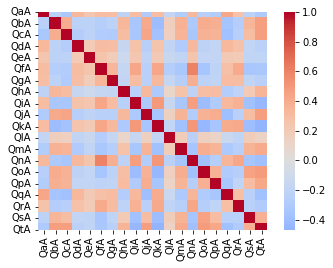

In [28]:
#마키아벨리즘 테스트스코어 계산

#reverse 처리를 안하고 문항간 Spearman correlation을 계산했을 경우 

answers = ['QaA', 'QbA', 'QcA', 'QdA', 'QeA',
             'QfA', 'QgA', 'QhA', 'QiA', 'QjA', 
             'QkA', 'QlA', 'QmA', 'QnA', 'QoA', 
             'QpA', 'QqA', 'QrA', 'QsA', 'QtA']

correlations = train[answers].corr(method='spearman')
sns.heatmap(correlations, cmap='coolwarm', square=True, center=0)

In [29]:
#"QeA", "QfA", "QkA", "QqA", "QrA" 문항 reverse 처리 

reverse_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
for Q_A in reverse_columns: 
    train[Q_A] = 6 - train[Q_A]

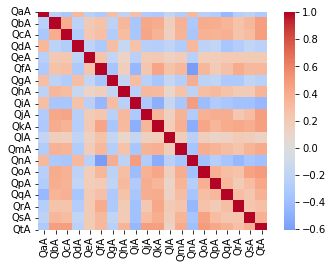

In [30]:
correlations = train[answers].corr(method = 'spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

In [31]:
# (-)부호인 secret 문항 reverse 처리
secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
for Q_A in secret_columns: 
    train[Q_A] = 6 - train[Q_A]

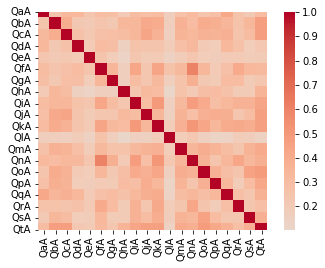

In [32]:
correlations = train[answers].corr(method='spearman')
sns.heatmap(correlations, cmap="coolwarm", square=True, center=0)

In [33]:
from scipy.sparse import data
def engineer(data):

  #역문항 reverse 처리
  
  reverse_columns = ["QeA", "QfA", "QkA", "QqA", "QrA"]
  for Q_A in reverse_columns: 
    data[Q_A] = 6 - data[Q_A]

  # 역문항 secret reverse 처리
  secret_columns = ["QaA", "QdA", "QgA", "QiA", "QnA"]
  for Q_A in secret_columns: 
    data[Q_A] = 6 - data[Q_A]

  #wr
  wrs = ['wr_01', 'wr_02', 'wr_03', 'wr_04','wr_05', 'wr_06','wr_07', 
         'wr_08','wr_09', 'wr_10','wr_11', 'wr_12','wr_13']
  data['wr_count'] = data[wrs].sum(axis=1)

  #wf
  wfs = ['wf_01', 'wf_02', 'wf_03']
  data['wf_count'] = data[wfs].sum(axis=1)

  drop1 = ['wr_01', 'wr_02', 'wr_03', 'wr_04','wr_05', 'wr_06','wr_07', 
         'wr_08','wr_09', 'wr_10','wr_11', 'wr_12','wr_13', 'wf_01', 'wf_02', 'wf_03']
  data = data.drop(drop1, axis = 1)
  
  return data

train = engineer(train)
test = engineer(test)

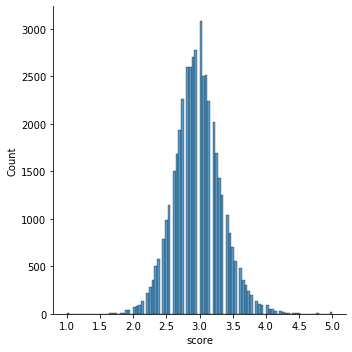

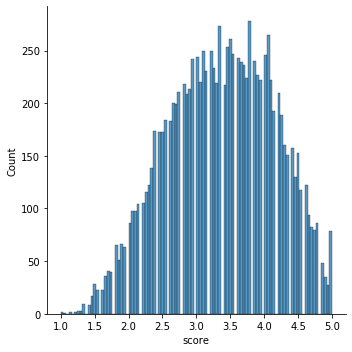

In [34]:
train['score'] = train[answers].mean(axis=1)
test['score'] = test[answers].mean(axis=1)

train = train.drop(answers, axis = 1)
test = test.drop(answers, axis = 1)

sns.displot(train, x='score', bins=100)
sns.displot(test, x='score', bins=100)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

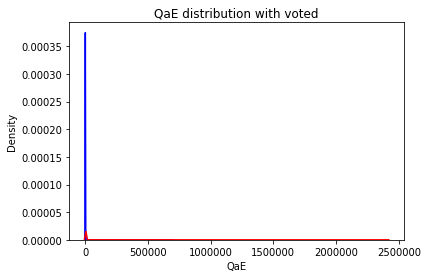

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

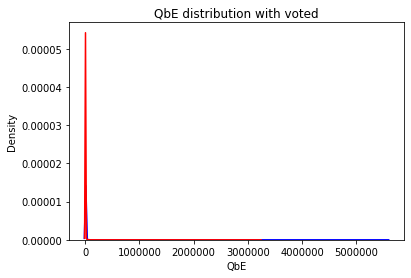

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

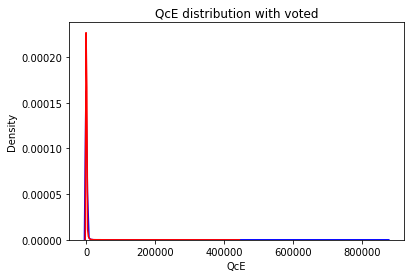

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

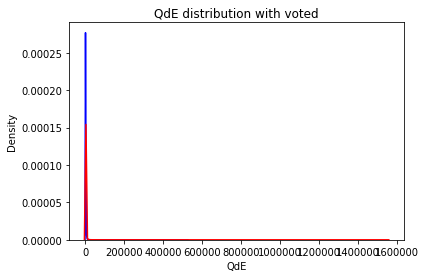

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

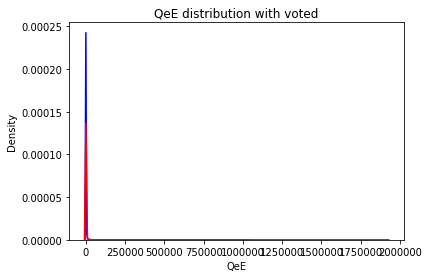

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

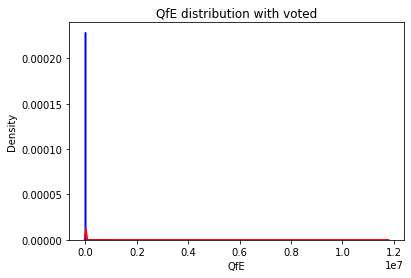

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

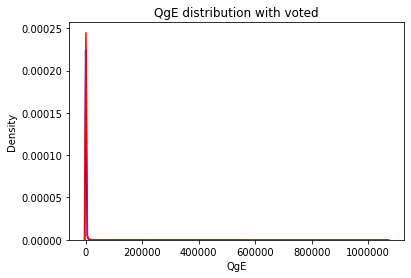

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

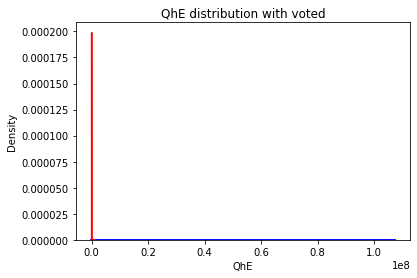

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

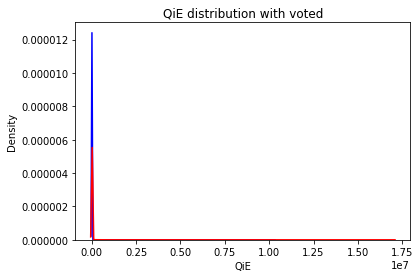

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

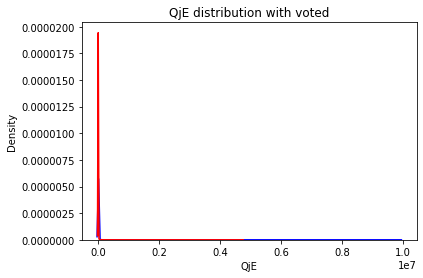

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

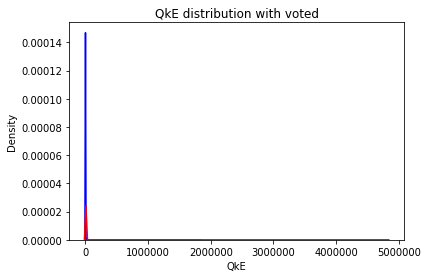

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

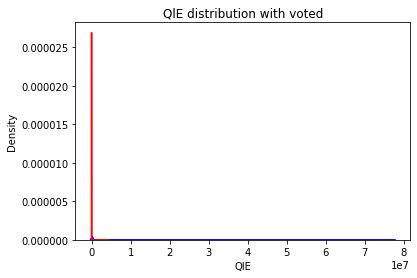

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

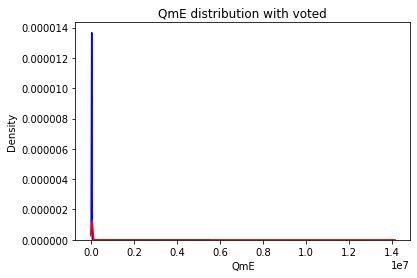

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

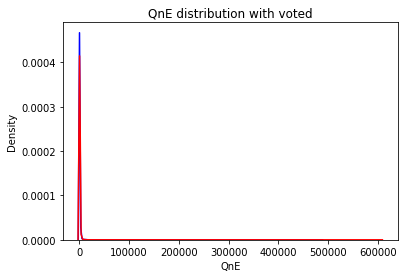

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

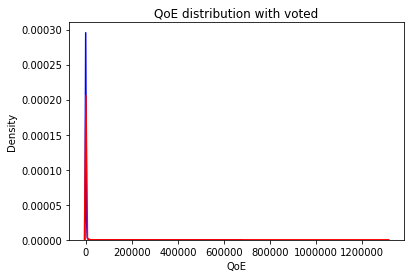

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

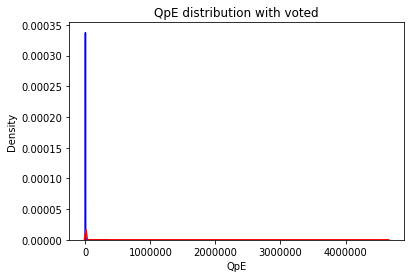

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

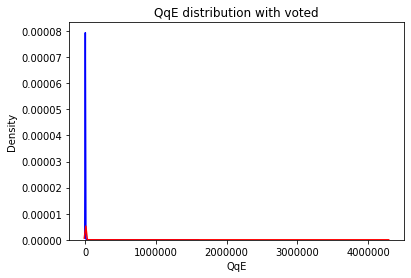

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

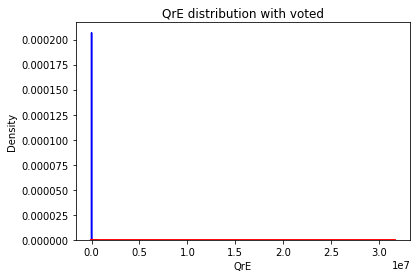

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

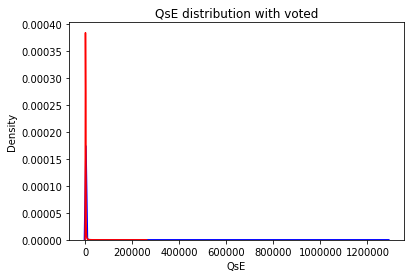

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

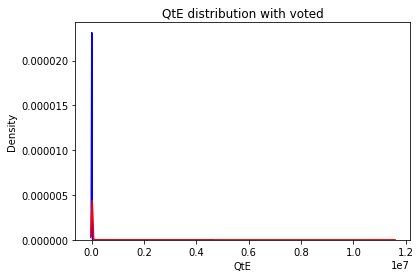

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


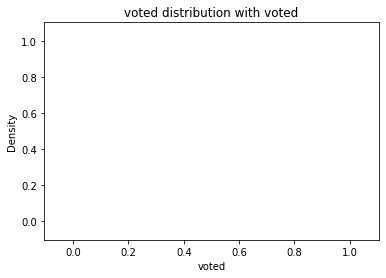

In [35]:
import matplotlib.pyplot as plt
%matplotlib inline

Q_E_kde = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE', 'voted']

for i in Q_E_kde:
  sns.kdeplot(train[i][train.voted == 0], color = 'b', label = 'voted')
  sns.kdeplot(train[i][train.voted == 1], color ='r', label = 'unvoted')
  plt.title(i + ' distribution with voted')
  plt.show()


In [36]:
#응답시간 데이터들이 극단적으로 치우쳐져있어, 로그를 취함

import numpy as np

def timelog(data):
  Q_E = ['QaE', 'QbE', 'QcE', 'QdE', 'QeE',
             'QfE', 'QgE', 'QhE', 'QiE', 'QjE', 
             'QkE', 'QlE', 'QmE', 'QnE', 'QoE', 
             'QpE', 'QqE', 'QrE', 'QsE', 'QtE']
             
  log_Q_E = np.log1p(data[Q_E].copy())
  data[Q_E] = log_Q_E
  return data

train = timelog(train)
test = timelog(test)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

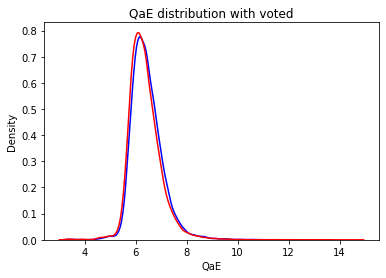

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

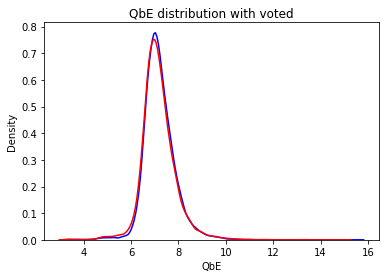

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

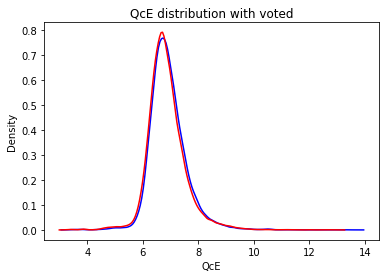

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

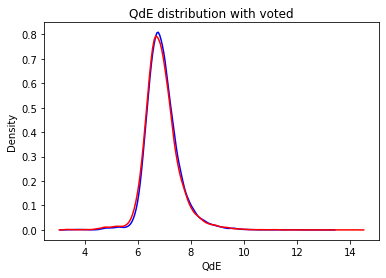

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

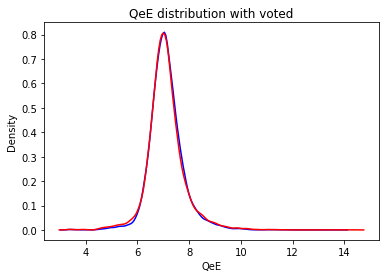

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

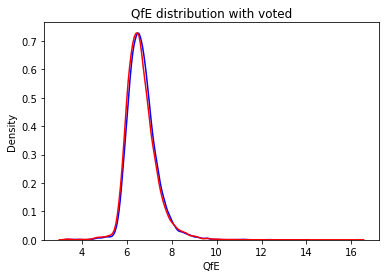

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

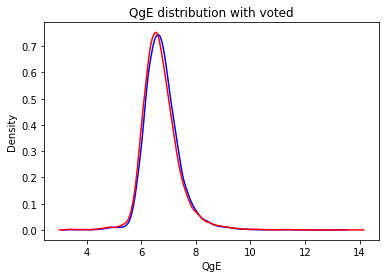

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

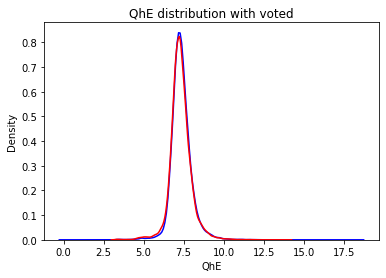

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

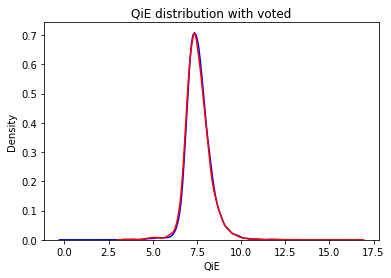

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

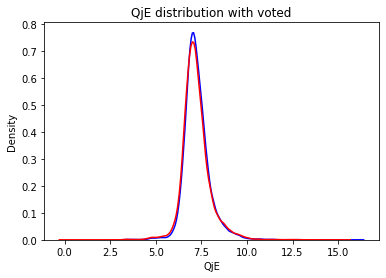

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

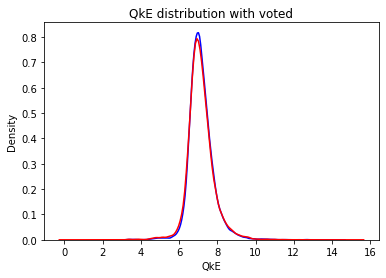

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

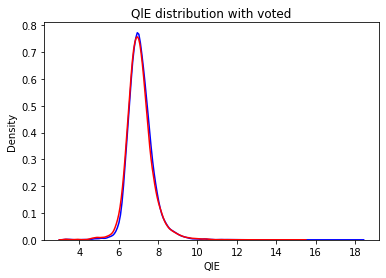

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

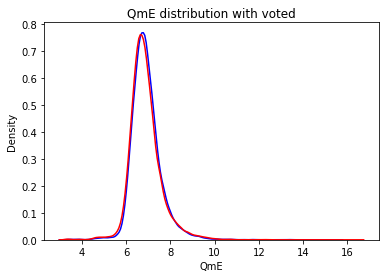

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

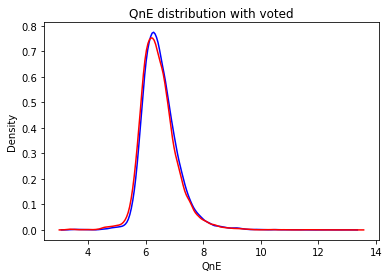

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

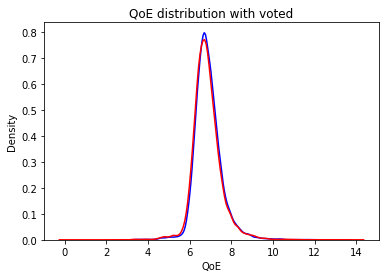

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

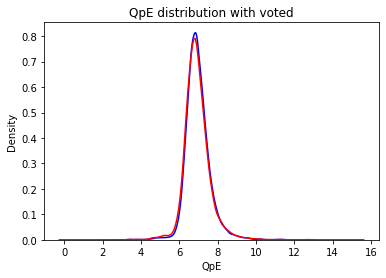

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

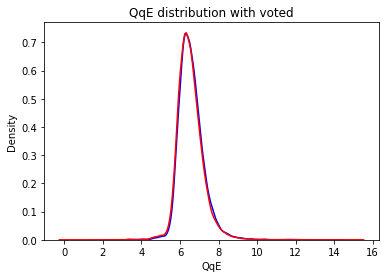

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

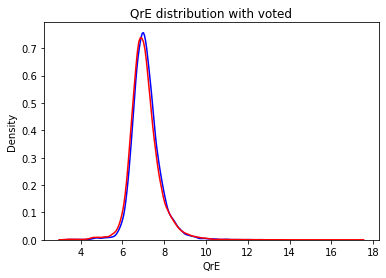

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

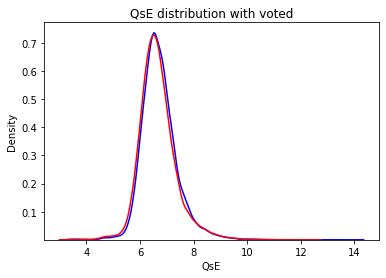

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]
/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed

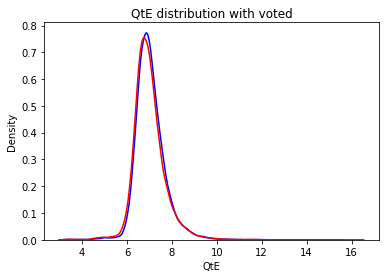

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)


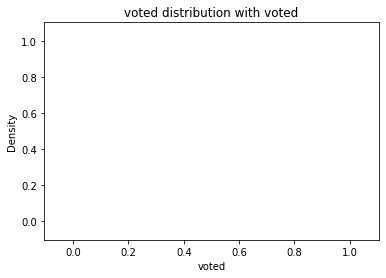

In [37]:
for i in Q_E_kde:
  sns.kdeplot(train[i][train.voted == 0], color = 'b', label = 'voted')
  sns.kdeplot(train[i][train.voted == 1], color ='r', label = 'unvoted')
  plt.title(i + ' distribution with voted')
  plt.show()

In [38]:
def tp(data):
   data['tp06'] = 8 - data['tp06']
   data['tp02'] = 8 - data['tp02']
   data['tp08'] = 8 - data['tp08']
   data['tp04'] = 8 - data['tp04']
   data['tp10'] = 8 - data['tp10']
   
   data['extreversion_score'] = data['tp01'] + data['tp06'] 
   data['agreeableness_score'] = data['tp07'] + data['tp02'] 
   data['conscientiousness_score'] = data['tp03'] + data['tp08']
   data['emotionalstability_score'] = data['tp09'] + data['tp04'] 
   data['opennessexperiences_score'] = data['tp05'] + data['tp10']
   
   drop = ['tp01', 'tp02', 'tp03', 'tp04','tp05','tp06','tp07','tp08','tp09','tp10']
   data = data.drop(drop, axis = 1)
   
   return(data)

train = tp(train)
test = tp(test)

In [39]:
print('train : ',train.isnull().sum())
print('test : ',test.isnull().sum())

train :  QaE                          0
QbE                          0
QcE                          0
QdE                          0
QeE                          0
QfE                          0
QgE                          0
QhE                          0
QiE                          0
QjE                          0
QkE                          0
QlE                          0
QmE                          0
QnE                          0
QoE                          0
QpE                          0
QqE                          0
QrE                          0
QsE                          0
QtE                          0
age_group                    0
education                    0
engnat                       0
familysize                   0
gender                       0
hand                         0
married                      0
race                         0
religion                     0
urban                        0
voted                        0
wr_count                     0

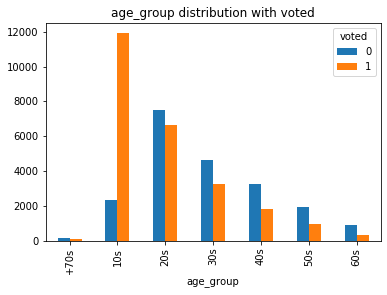

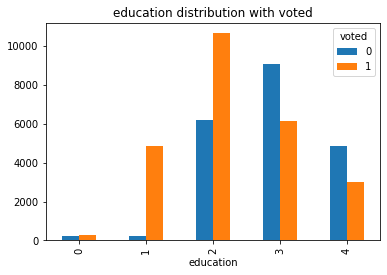

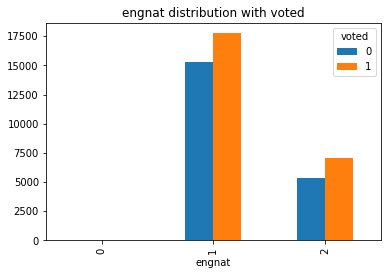

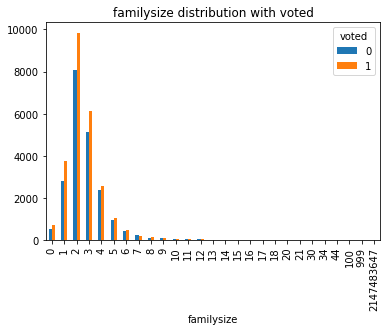

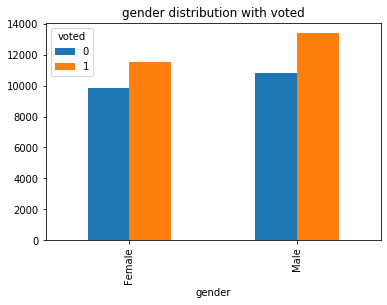

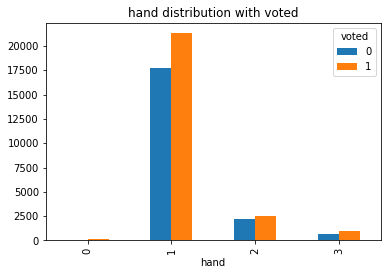

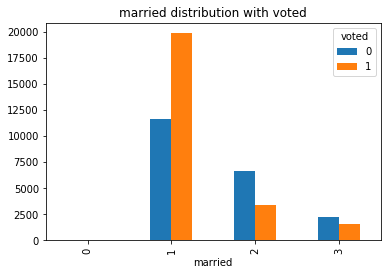

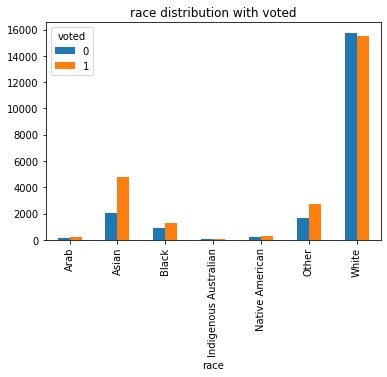

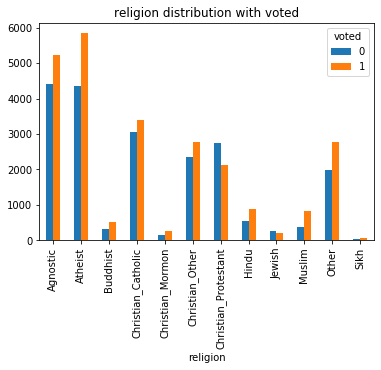

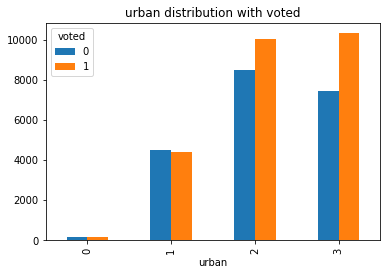

In [40]:
cat_features = ['age_group', 'education', 'engnat', 'familysize', 'gender', 'hand',
       'married', 'race', 'religion', 'urban']

for i in cat_features:
  pd.crosstab(train[i],train['voted']).plot.bar()
  plt.title(i + ' distribution with voted')

In [41]:
#String 형태의 Data를 가진 Feature에 대해 Label Encoding을 진행하고, 원본 Feature는 제거
from sklearn.preprocessing import LabelEncoder

label = LabelEncoder()
train['gender_code'] = label.fit_transform(train['gender'])
train['race_code'] = label.fit_transform(train['race'])
train['religion_code'] = label.fit_transform(train['religion'])

test['gender_code'] = label.fit_transform(test['gender'])
test['race_code'] = label.fit_transform(test['race'])
test['religion_code'] = label.fit_transform(test['religion'])

drop2 = ['gender','race','religion']
train = train.drop(drop2, axis = 1)
test = test.drop(drop2, axis = 1)

In [42]:
#familysize 이상치 제거
train = train.drop(train[train.familysize >= 10].index)
test = test.drop(test[test.familysize >= 10].index)

#투표 여부에 대한 예측이므로 10대 구분
train['teen'] = 1*np.array(train['age_group'] == '10s')
test['teen'] = 1*np.array(test['age_group'] == '10s')

In [43]:
from sklearn.model_selection import train_test_split

target = 'voted'
features = train.drop(columns=[target]).columns

train, val = train_test_split(train, test_size=0.2, stratify=train[target], random_state= 42)

train.shape, val.shape, test.shape

((36293, 40), (9074, 40), (11349, 39))

In [44]:
# 훈련/검증/테스트 데이터를 특성과 타겟으로 분리합니다
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

In [45]:
from sklearn.metrics import confusion_matrix, accuracy_score
from xgboost import plot_importance
import xgboost as xgb
from sklearn.model_selection import cross_val_score

#베이스라인 

pipe = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
                 ('XGB', XGBClassifier())
    ])

pipe.fit(X_train, y_train)
baseline = cross_val_score(pipe, X_train, y_train, cv = 3, scoring= 'roc_auc')
print('기본 점수 : ', np.mean(baseline))

기본 점수 :  0.7608548337989317


In [46]:
from sklearn.model_selection import RandomizedSearchCV

import sklearn
import xgboost
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

pipe1 = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
                 ('XGB', XGBClassifier(n_estimators=100
                                       , random_state=2
                                       , n_jobs=-1
                                       , max_depth=7
                                       , learning_rate=0.2))
    ])

pipe1.fit(X_train, y_train)
y_pred_proba = pipe1.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))
print(classification_report(y_val, pipe1.predict(X_val)))

AUC score:  0.7539360524731841
              precision    recall  f1-score   support

           0       0.63      0.72      0.67      4110
           1       0.74      0.65      0.69      4964

    accuracy                           0.68      9074
   macro avg       0.68      0.69      0.68      9074
weighted avg       0.69      0.68      0.68      9074



In [47]:
pipe2 = Pipeline([
                 ('preprocessing', make_pipeline(OrdinalEncoder(), SimpleImputer())),
                 ('XGB', XGBClassifier(n_estimators=100
                                       , random_state=2
                                       , n_jobs=-1
                                       , max_depth=7
                                       , learning_rate=0.2
                                       , objective='binary:logistic'))
    ])

dists = {
    'XGB__max_depth': [6, 10, 15, 20],
    'XGB__learning_rate': [0.05, 0.1, 0.2, 0,3],
    'XGB__gamma' : [0, 1, 10, 16],
    'XGB__min_child_weight' : [1, 3, 5],
    'XGB__colsample_bytree' : [0.4, 0.5, 1], 
    }
    
clf = RandomizedSearchCV(
    pipe2,
    param_distributions=dists,
    n_iter = 5,
    cv=2, 
    verbose=2, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=2)

clf.fit(X_train, y_train)

print("Optimal Hyperparameter:", clf.best_params_)
print("AUC:", clf.best_score_)

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Optimal Hyperparameter: {'XGB__min_child_weight': 3, 'XGB__max_depth': 6, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0, 'XGB__colsample_bytree': 1}
AUC: 0.7572586309341489


In [48]:
#각 하이퍼파라미터 조합으로 만들어진 모델들을 순위별로 나열해 봅니다.
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,2,4,0,1,3
mean_fit_time,9.067254,5.179168,1.632653,36.304278,34.839229
std_fit_time,0.042739,0.092452,0.062503,0.017349,0.05726
mean_score_time,0.25018,0.098007,0.07481,0.410698,0.404383
std_score_time,0.011495,0.015742,0.005158,0.000447,0.02441
param_XGB__min_child_weight,3,1,1,5,5
param_XGB__max_depth,6,15,6,20,15
param_XGB__learning_rate,0.1,3,3,0,0
param_XGB__gamma,0,0,10,0,1
param_XGB__colsample_bytree,1,1,0.4,1,1
params,"{'XGB__min_child_weight': 3, 'XGB__max_depth':...","{'XGB__min_child_weight': 1, 'XGB__max_depth':...","{'XGB__min_child_weight': 1, 'XGB__max_depth':...","{'XGB__min_child_weight': 5, 'XGB__max_depth':...","{'XGB__min_child_weight': 5, 'XGB__max_depth':..."


In [49]:
clf.best_estimator_

Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('ordinalencoder',
                                  OrdinalEncoder(cols=['age_group'],
                                                 mapping=[{'col': 'age_group',
                                                           'data_type': dtype('O'),
                                                           'mapping': 10s     1
30s     2
50s     3
20s     4
40s     5
60s     6
+70s    7
NaN    -2
dtype: int64}])),
                                 ('simpleimputer', SimpleImputer())])),
                ('XGB',
                 XGBClassifier(max_depth=6, min_child_weight=3, n_jobs=-1,
                               random_state=2))])

In [50]:
pipe2_1 = clf.best_estimator_
pipe2_1.fit(X_train, y_train)
y_pred_proba = pipe.predict_proba(X_val)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba)) 
print(classification_report(y_val, pipe.predict(X_val)))

AUC score:  0.7636680204528566
              precision    recall  f1-score   support

           0       0.64      0.75      0.69      4110
           1       0.76      0.65      0.70      4964

    accuracy                           0.69      9074
   macro avg       0.70      0.70      0.69      9074
weighted avg       0.70      0.69      0.69      9074



In [51]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

!pip install eli5==0.11.0

import eli5
from eli5.sklearn import PermutationImportance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [52]:
#n233
#모델의 Permutation importances 

permuter = PermutationImportance(
    pipe.named_steps['XGB'], # model
    scoring='roc_auc', # metric
    n_iter=5, # 다른 random seed를 사용하여 5번 반복
    random_state=2
)

X_val_transformed = pipe.named_steps['preprocessing'].transform(X_val)

permuter.fit(X_val_transformed, y_val);

In [53]:
feature_names = X_val.columns.tolist()
pd.Series(permuter.feature_importances_, feature_names).sort_values()

QcE                         -0.000615
QdE                         -0.000261
QoE                         -0.000198
familysize                  -0.000142
QqE                         -0.000133
agreeableness_score         -0.000110
QhE                         -0.000055
QmE                         -0.000052
opennessexperiences_score   -0.000006
teen                         0.000000
hand                         0.000000
QaE                          0.000044
QtE                          0.000049
QlE                          0.000050
QiE                          0.000056
QgE                          0.000072
QkE                          0.000094
QfE                          0.000099
QjE                          0.000106
QpE                          0.000108
QrE                          0.000125
QnE                          0.000138
gender_code                  0.000198
QbE                          0.000236
score                        0.000286
QsE                          0.000426
QeE         

In [54]:
# 특성별 score 확인
eli5.show_weights(
    permuter, 
    top=None, # top n 지정 가능, None 일 경우 모든 특성 
    feature_names=feature_names # list 형식으로 넣어야 합니다
)

Weight,Feature
0.0782 ± 0.0076,age_group
0.0516 ± 0.0087,education
0.0249 ± 0.0039,race_code
0.0058 ± 0.0018,married
0.0029 ± 0.0007,religion_code
0.0015 ± 0.0007,engnat
0.0013 ± 0.0005,extreversion_score
0.0013 ± 0.0008,emotionalstability_score
0.0011 ± 0.0005,wf_count
0.0011 ± 0.0008,wr_count


In [55]:
print('특성 삭제 전:', X_train.shape, X_val.shape)

특성 삭제 전: (36293, 39) (9074, 39)


In [56]:
minimum_importance = 0
mask = permuter.feature_importances_ >= minimum_importance
features = X_train.columns[mask]
X_train_selected = X_train[features]
X_val_selected = X_val[features]
X_test_selected = X_test[features]

In [57]:
print('특성 삭제 후:', X_train_selected.shape, X_val_selected.shape)

특성 삭제 후: (36293, 30) (9074, 30)


In [58]:
X_train_selected.columns

Index(['QaE', 'QbE', 'QeE', 'QfE', 'QgE', 'QiE', 'QjE', 'QkE', 'QlE', 'QnE',
       'QpE', 'QrE', 'QsE', 'QtE', 'age_group', 'education', 'engnat', 'hand',
       'married', 'urban', 'wr_count', 'wf_count', 'score',
       'extreversion_score', 'conscientiousness_score',
       'emotionalstability_score', 'gender_code', 'race_code', 'religion_code',
       'teen'],
      dtype='object')

In [59]:
dists = {
    'XGB__max_depth': [6, 10, 15, 20],
    'XGB__learning_rate': [0.05, 0.1, 0.2, 0,3],
    'XGB__gamma' : [0, 1, 10, 16],
    'XGB__min_child_weight' : [1, 3, 5],
    'XGB__colsample_bytree' : [0.4, 0.5, 1], 
    }
    
clf = RandomizedSearchCV(
    pipe2,
    param_distributions=dists,
    n_iter = 5,
    cv=2, 
    verbose=2, 
    scoring='roc_auc',
    n_jobs=-1,
    random_state=2)

clf.fit(X_train_selected, y_train)

print("Optimal Hyperparameter:", clf.best_params_)
print("AUC:", clf.best_score_)
#모델이 더 효율적이게 됨

Fitting 2 folds for each of 5 candidates, totalling 10 fits
Optimal Hyperparameter: {'XGB__min_child_weight': 3, 'XGB__max_depth': 6, 'XGB__learning_rate': 0.1, 'XGB__gamma': 0, 'XGB__colsample_bytree': 1}
AUC: 0.7569321394933463


In [60]:
pipe3 = clf.best_estimator_
pipe3.fit(X_train_selected, y_train)
y_pred_proba = pipe3.predict_proba(X_val_selected)[:, -1]
print('AUC score: ', roc_auc_score(y_val, y_pred_proba))

AUC score:  0.7640613634714961


In [61]:
# 클래스의 비율
y_train.value_counts(normalize=True)

1    0.547075
0    0.452925
Name: voted, dtype: float64

In [62]:
ratio = 0.45/0.54
ratio

0.8333333333333333

In [82]:
processor =  make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(strategy='median')
)

X_train_processed = processor.fit_transform(X_train)
X_val_processed = processor.transform(X_val)

eval_set = [(X_train_processed, y_train), 
            (X_val_processed, y_val)]

model = XGBClassifier(n_estimators=1000, verbosity=0, n_jobs=-1, scale_pos_weight=ratio)
model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='auc', 
          early_stopping_rounds=10)

[0]	validation_0-auc:0.736335	validation_1-auc:0.7398
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 10 rounds.
[1]	validation_0-auc:0.741917	validation_1-auc:0.745806
[2]	validation_0-auc:0.741012	validation_1-auc:0.744785
[3]	validation_0-auc:0.749558	validation_1-auc:0.752031
[4]	validation_0-auc:0.752088	validation_1-auc:0.754865
[5]	validation_0-auc:0.751606	validation_1-auc:0.754544
[6]	validation_0-auc:0.752584	validation_1-auc:0.755574
[7]	validation_0-auc:0.752469	validation_1-auc:0.755391
[8]	validation_0-auc:0.752464	validation_1-auc:0.755391
[9]	validation_0-auc:0.751816	validation_1-auc:0.754861
[10]	validation_0-auc:0.752631	validation_1-auc:0.755586
[11]	validation_0-auc:0.752723	validation_1-auc:0.755821
[12]	validation_0-auc:0.754556	validation_1-auc:0.757137
[13]	validation_0-auc:0.755367	validation_1-auc:0.75743
[14]	validation_0-auc:0.755331	validation_1-auc:0.757519
[

XGBClassifier(n_estimators=1000, n_jobs=-1, scale_pos_weight=0.8333333333333333,
              verbosity=0)

In [64]:
class_index = 1
y_pred_proba = model.predict_proba(X_val_processed)[:, class_index]
print(f'val AUC for class "{model.classes_[class_index]}":')
print(roc_auc_score(y_val, y_pred_proba)) # 범위는 0-1, 수치는 높을 수록 좋습니다

val AUC for class "1":
0.7638021246894919


In [65]:
# Confution matrix를 확인해 봅시다
from sklearn.metrics import classification_report
y_val_pred = model.predict(X_val_processed)
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.62      0.83      0.71      4110
           1       0.80      0.58      0.67      4964

    accuracy                           0.69      9074
   macro avg       0.71      0.70      0.69      9074
weighted avg       0.72      0.69      0.69      9074



In [66]:
y_val

index
26185    1
39454    1
44799    0
402      0
32176    0
        ..
40762    1
44464    0
19365    1
42666    1
15018    1
Name: voted, Length: 9074, dtype: int64

In [67]:
#예측값 vs 실제값을 비교
val_id = y_val.index

df_p = pd.DataFrame({ 
    'pred_proba': y_pred_proba, # 예측확률 
    'status_group': y_val # 실제값
})

In [68]:
top = df_p.sort_values(by='pred_proba', ascending=True)
top

,pred_proba,status_group
index,,
33049,0.193614,0
14731,0.195022,0
38403,0.195722,0
40743,0.198900,0
41450,0.199319,0
...,...,...
4402,0.971108,1
30300,0.971135,1
42757,0.971832,1


In [69]:
X_val_selected

,QaE,QbE,QeE,QfE,QgE,QiE,QjE,QkE,QlE,QnE,...,wr_count,wf_count,score,extreversion_score,conscientiousness_score,emotionalstability_score,gender_code,race_code,religion_code,teen
index,,,,,,,,,,,,,,,,,,,,,
26185,6.192362,7.432484,7.091742,6.688355,6.545350,6.905753,6.961296,7.158514,7.675546,6.393591,...,8,1,3.50,8,4,6,0,6,3,1
39454,7.446585,8.174139,7.126087,6.824374,7.101676,7.368340,7.954372,6.909753,7.947325,6.758095,...,9,1,3.15,6,3,4,1,6,3,1
44799,5.743003,6.489205,6.697034,5.986452,6.727432,7.131699,6.579251,6.459904,6.857514,5.556828,...,13,0,3.50,11,3,10,0,6,10,0
402,7.450661,8.111028,6.944087,6.716595,6.815640,8.220403,7.169350,7.115582,7.517521,7.029973,...,8,0,3.10,13,5,5,1,6,5,0
32176,6.306275,7.218910,8.315811,7.440147,6.709304,7.244942,7.113956,8.155936,6.357842,6.410175,...,7,0,3.05,11,5,8,0,6,6,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40762,5.497168,6.037871,5.755742,5.934894,6.448889,6.276643,6.052089,5.872118,6.098074,5.899897,...,8,0,1.60,2,6,7,1,1,6,1
44464,6.272877,8.214465,7.501082,6.924612,5.398163,7.789040,7.139660,7.029973,7.054450,6.107023,...,7,0,2.90,14,8,9,0,1,5,1
19365,6.248043,5.857933,6.109248,5.780744,5.468060,7.060476,6.721426,5.613128,5.880533,5.645447,...,11,0,2.95,14,13,13,0,6,0,0


In [70]:
X_test_26185 = X_val_selected.loc[[26185]]
X_test_26185

X_test_40762 = X_val_selected.loc[[40762]]
X_test_40762

y_26185_pred = pipe3.predict(X_test_26185)
print('26185 투표여부 예측:', y_26185_pred)
y_40762_pred = pipe3.predict(X_test_40762)
print('40762 투표여부 예측:', y_40762_pred)

26185 투표여부 예측: [1]
40762 투표여부 예측: [1]


In [71]:
y_26185_pred_proba = pipe3.predict_proba(X_test_26185)[:, 1]
print('26185 투표를 하지 않았을 확률: ', y_26185_pred_proba)
y_40762_pred_proba = pipe3.predict_proba(X_test_40762)[:, 1]
print('1541 투표를 하지 않았을 확률: ', y_40762_pred_proba)

26185 투표를 하지 않았을 확률:  [0.8224992]
1541 투표를 하지 않았을 확률:  [0.9836819]


In [72]:
print(y_val.loc[[26185]])
print(y_val.loc[[40762]])

index
26185    1
Name: voted, dtype: int64
index
40762    1
Name: voted, dtype: int64


In [73]:
%%capture

# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

In [74]:
!pip install pdpbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f508924e090>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5089319550>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


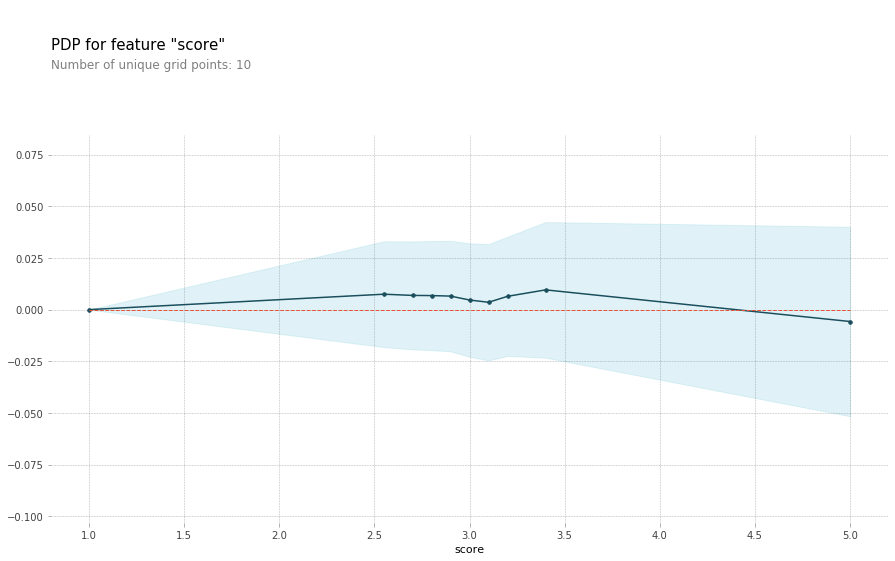

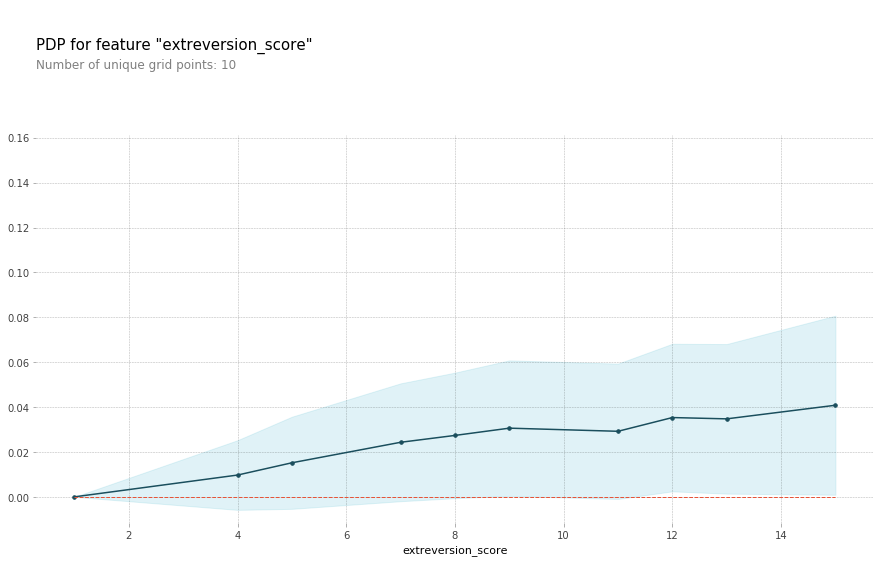

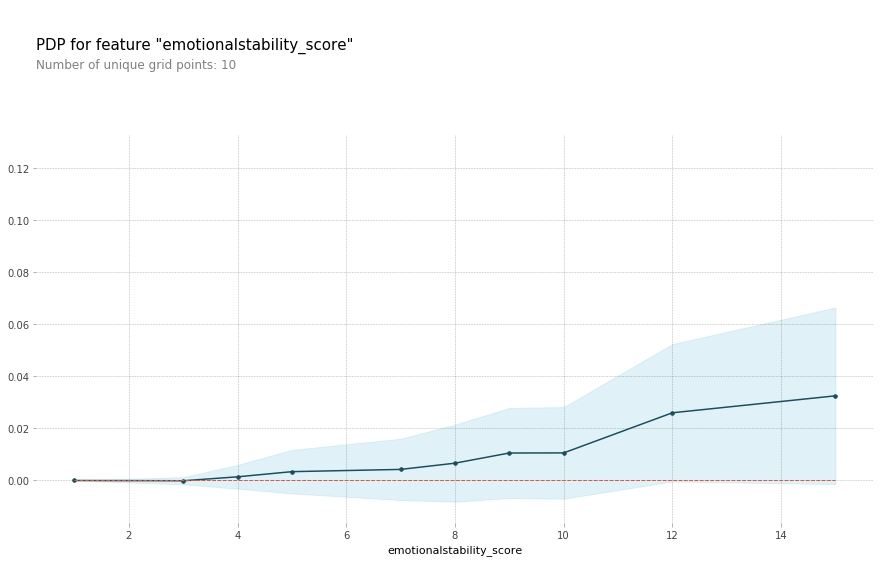

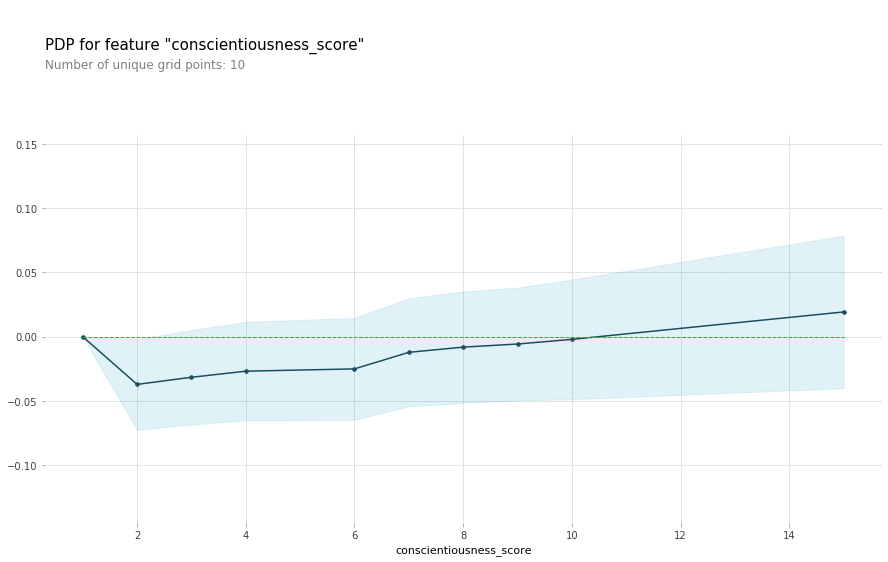

In [75]:
import matplotlib.pyplot as plt
from pdpbox.pdp import pdp_isolate, pdp_plot
from pdpbox import pdp

def pdp(feature):
  isolated = pdp_isolate(
    model=pipe3, dataset=X_val_selected, model_features=X_val_selected.columns, feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
)
  
  return pdp_plot(isolated, feature_name=feature);


pdp('score')
pdp('extreversion_score')
pdp('emotionalstability_score')
pdp('conscientiousness_score')

#pdp_dist = pdp.pdp_isolate(model=pipe3, dataset=X_val_selected, model_features=X_val_selected.columns, feature=feature)
#pdp.pdp_plot(pdp_dist, feature); 

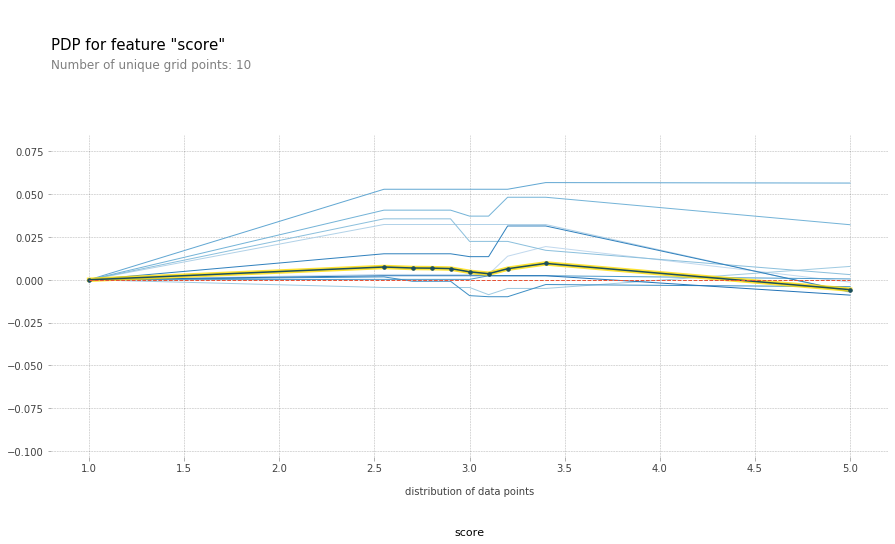

In [78]:
feature='score'

isolated = pdp_isolate(
    model=pipe3, dataset=X_val_selected, model_features=X_val_selected.columns, feature=feature,
    grid_type='percentile', # default='percentile', or 'equal'
    num_grid_points=10 # default=10
    )

pdp_plot(isolated
         , feature_name=feature
         , plot_lines=True # ICE plots
         , frac_to_plot= 10 
         , plot_pts_dist=True) 

plt.xlim(20000,150000);

(<Figure size 540x684 with 3 Axes>,
 {'pdp_inter_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5087b12f50>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7f5087b3b190>})

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


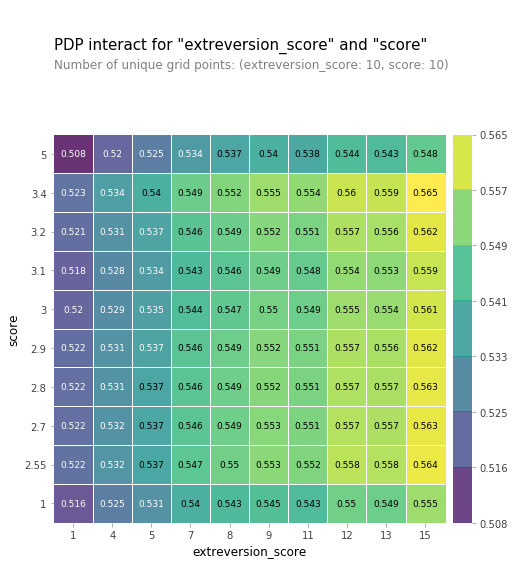

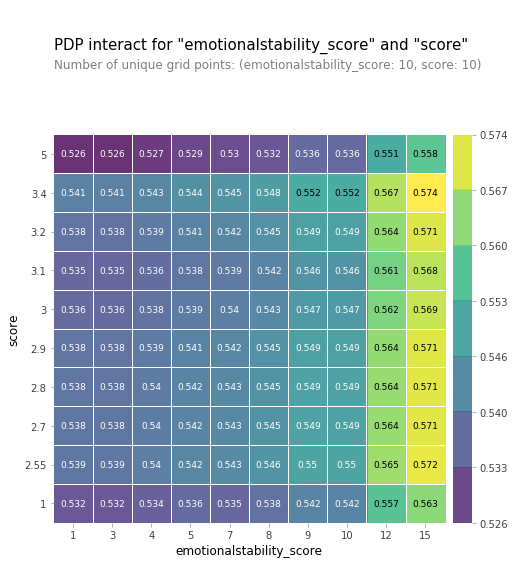

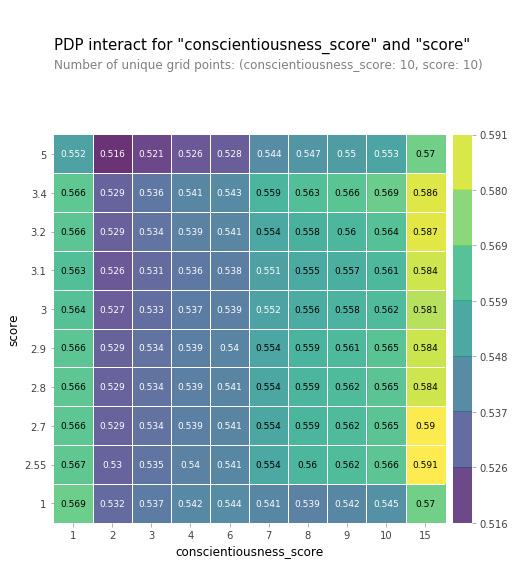

In [79]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['extreversion_score', 'score']

def pdp2(features):
  interaction = pdp_interact(
    model=pipe3, 
    dataset=X_val_selected, 
    model_features=X_val_selected.columns, 
    features = features
    )
  
  return pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

pdp2(['extreversion_score', 'score'])
pdp2(['emotionalstability_score', 'score'])
pdp2(['conscientiousness_score', 'score'])

#score에서 두드러지지 않음, tp 스코어에 따라 경향성이 두드러짐